# Air Quality in Dar es salaam

In [1]:
# Import libraries here
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

## Prepare Data

## Import

In [2]:
df = pd.read_csv('air_quality_in_dar_es_salaam.csv')

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
df.set_index('timestamp',inplace = True)

In [5]:
df.head()

,P2
timestamp,
2018-01-01 00:00:48.041,NaN
2018-01-01 00:03:17.441,NaN
2018-01-01 00:05:46.557,NaN
2018-01-01 00:08:16.972,NaN
2018-01-01 00:10:46.370,NaN


> <font size = '+0.5'>Localize reading time stamps to the timezone for `"Africa/Dar_es_Salaam"`.</font><br>
 <font size = '+0.5'>Remove all outlier PM2.5 readings that are above 100. <br>
 <font size = '+0.5'>Resample the data to provide the mean PM2.5 reading for each hour. <br>
 <font size = '+0.5'>Impute any missing values using the forward-will method. <br>

In [6]:
df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")

In [7]:
df = df[df["P2"] < 100]

In [8]:
y = df["P2"].resample("1H").mean().fillna(method='ffill')

In [9]:
y.head()

timestamp
2018-01-01 03:00:00+03:00    9.456327
2018-01-01 04:00:00+03:00    9.400833
2018-01-01 05:00:00+03:00    9.331458
2018-01-01 06:00:00+03:00    9.528776
2018-01-01 07:00:00+03:00    8.861250
Freq: H, Name: P2, dtype: float64

## Explore Data

C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


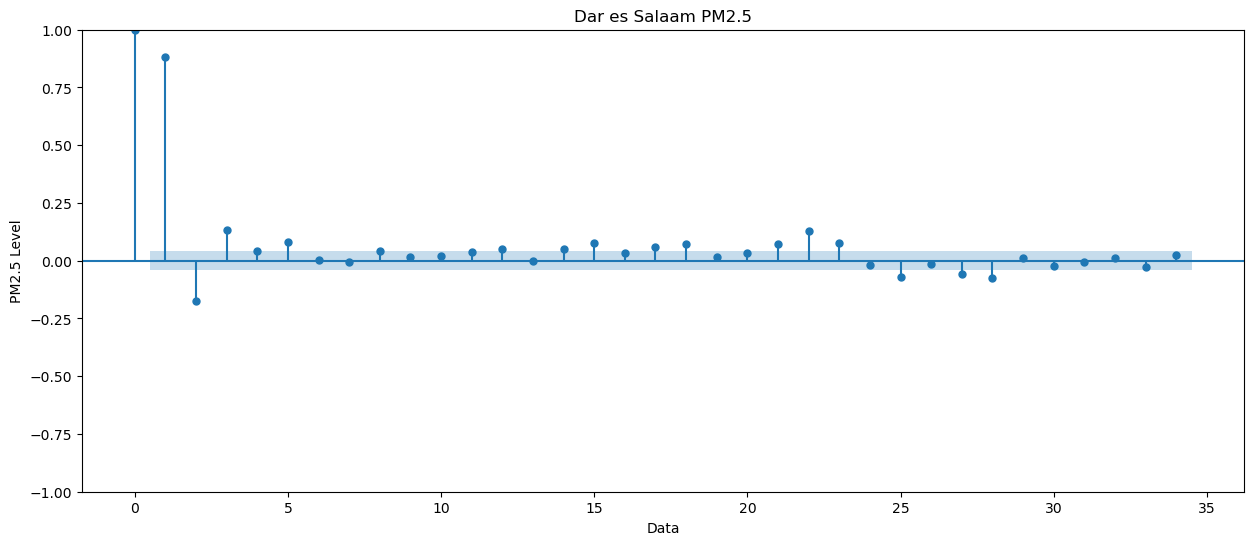

In [10]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.xlabel('Data')
plt.ylabel('PM2.5 Level')
plt.title('Dar es Salaam PM2.5')
plt.show()

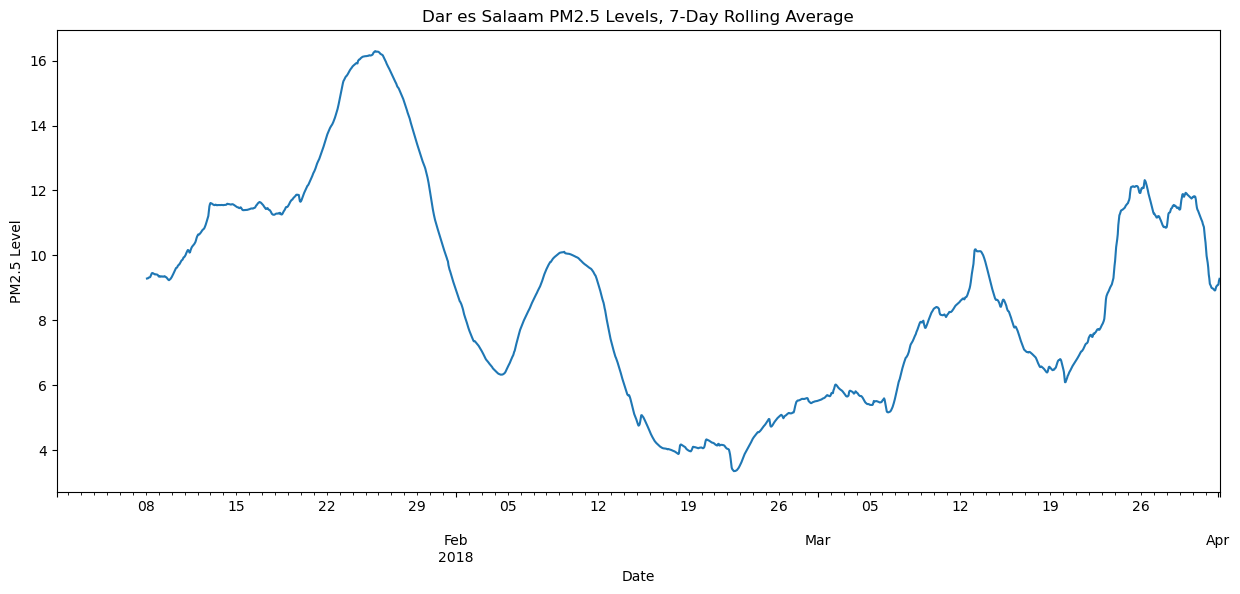

In [11]:
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(168).mean().plot(ax=ax);
plt.xlabel('Date')
plt.ylabel('PM2.5 Level')
plt.title("Dar es Salaam PM2.5 Levels, 7-Day Rolling Average")
plt.show()

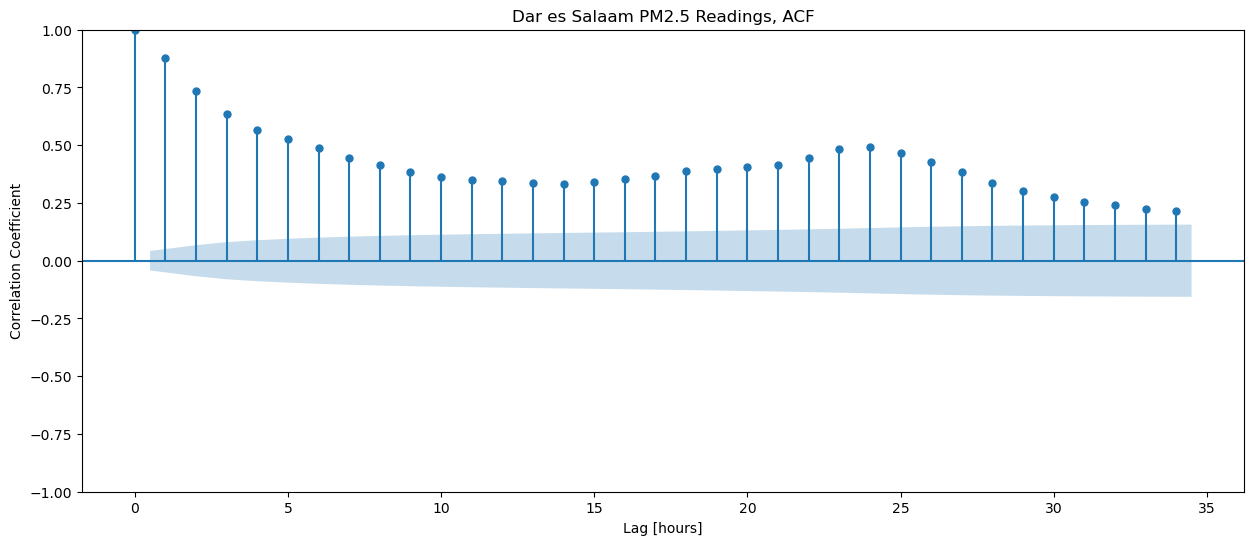

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y,ax=ax)
plt.xlabel('Lag [hours]')
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, ACF")
plt.show()

C:\Users\LENOVO\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


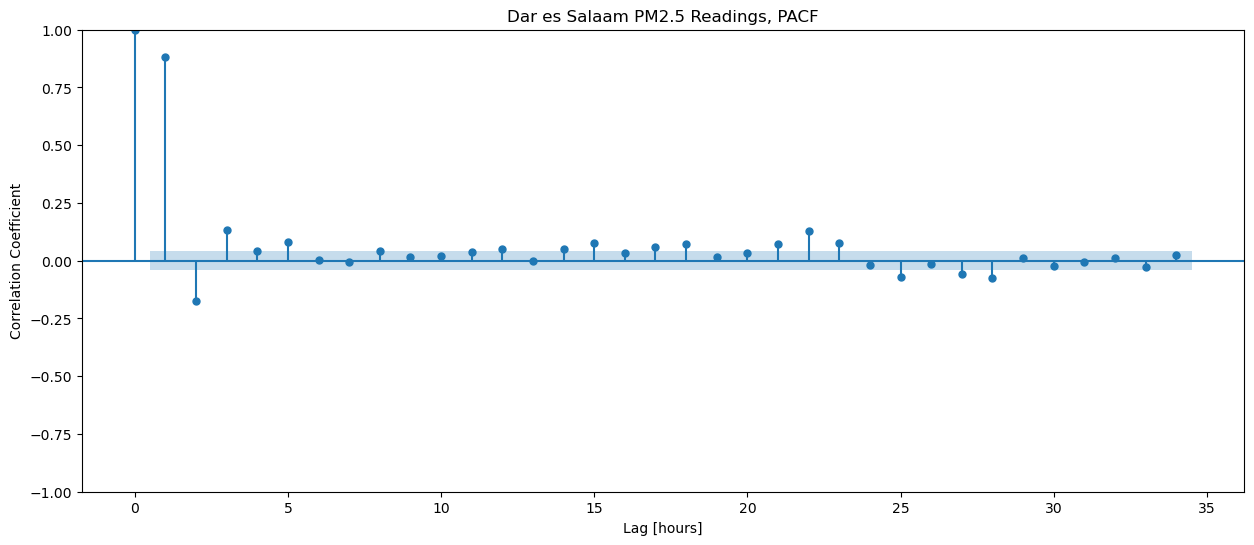

In [13]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y,ax = ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Dar es Salaam PM2.5 Readings, PACF")
plt.show()

## Split

In [14]:
cutoff_test = int(len(y) * .9)
y_train = y[:cutoff_test]
y_test = y[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1944,)
y_test shape: (216,)


# Build Model

## Baseline

In [15]:
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 8.571423190610778
Baseline MAE: 4.053101181299159


## Iterate

In [16]:
p_params = range(1, 31)
maes = []
for p in p_params:
    model = AutoReg(y_train,lags = p).fit();
    y_pred = model.predict().dropna()
    mae = mean_absolute_error(y_train.iloc[p:],y_pred)
    maes.append(mae)
    
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

1    1.059376
2    1.045182
3    1.032489
4    1.032147
5    1.031022
Name: mae, dtype: float64

In [17]:
mae_series[mae_series == mae_series.min()].index

Int64Index([26], dtype='int64')

In [18]:
best_p = 28
best_model = AutoReg(y_train,lags = 28).fit();

In [19]:
y_train_resid = model.resid
y_train_resid.name = "residuals"
y_train_resid.head()

timestamp
2018-01-02 09:00:00+03:00   -0.530654
2018-01-02 10:00:00+03:00   -2.185269
2018-01-02 11:00:00+03:00    0.112928
2018-01-02 12:00:00+03:00    0.590670
2018-01-02 13:00:00+03:00   -0.118088
Freq: H, Name: residuals, dtype: float64

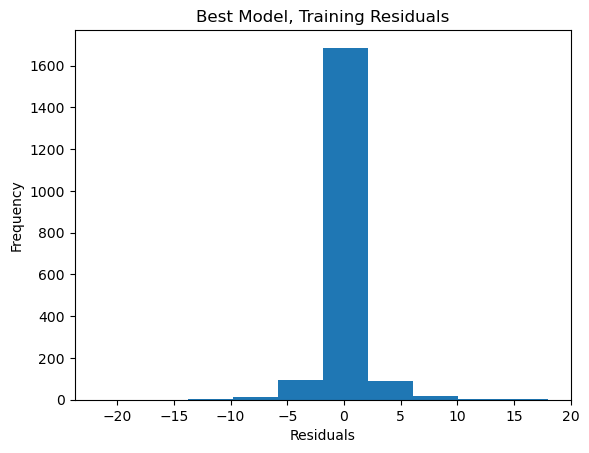

In [20]:
# Plot histogram of residuals
y_train_resid.plot(kind='hist')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Best Model, Training Residuals")
plt.show()

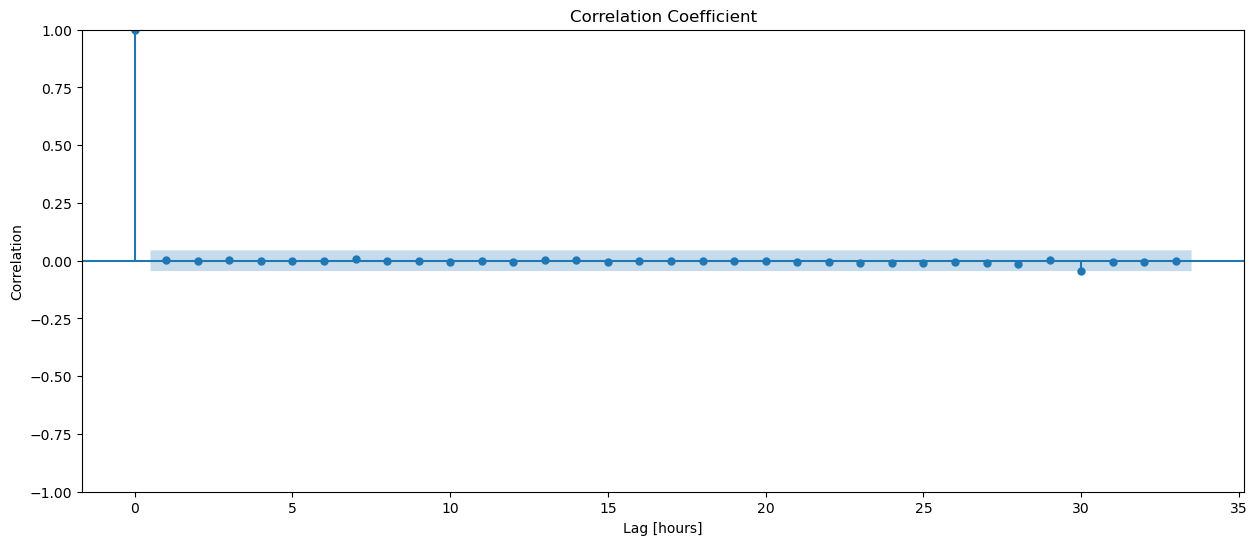

In [21]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax = ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation")
plt.title("Correlation Coefficient")
plt.show()

## Evaluate

In [22]:
y_pred_wfv = pd.Series(dtype='object')
history = y_train.copy()

In [23]:
for i in range(len(y_test)):
    model = AutoReg(history,lags = 28).fit();
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv,next_pred])
    history = pd.concat([history,y_test[next_pred.index]])

In [24]:
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2018-03-23 03:00:00+03:00    10.383307
2018-03-23 04:00:00+03:00     8.268941
2018-03-23 05:00:00+03:00    15.172779
2018-03-23 06:00:00+03:00    33.480666
2018-03-23 07:00:00+03:00    39.576329
Freq: H, Name: prediction, dtype: float64

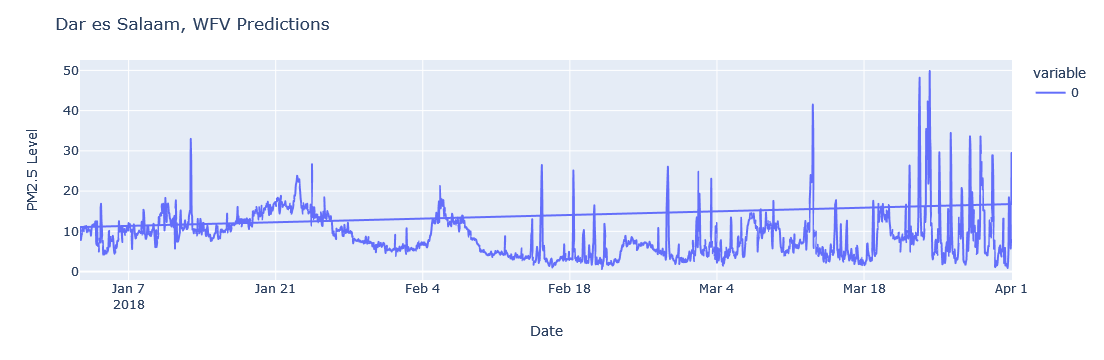

In [33]:
df_pred_test = pd.concat([y_test,y_pred])
fig = px.line(df_pred_test)

fig.update_layout(
    title="Dar es Salaam, WFV Predictions",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level"
)


fig.show()